In [147]:
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
from tqdm import tqdm

In [148]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

OUTPUT_DIR = os.path.join(PROJECT_ROOT, "output")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
FIG_DIR = os.path.join(PROJECT_ROOT, "figs")

os.makedirs(FIG_DIR, exist_ok=True)
X_INIT = 45750
step_x = 5
Nx = 200

In [149]:
x_range = range(X_INIT, X_INIT + step_x * Nx, step_x)
# list(x_range)

In [150]:
import glob, os, pprint
pprint.pprint(glob.glob(os.path.join(OUTPUT_DIR, "run_*")))

['/home/arcadia/FCFD-Laser/output/run_20251002_112401_Power_80.0%',
 '/home/arcadia/FCFD-Laser/output/run_20251002_160916_Power_80.0%']


In [151]:
def get_latest_run_dir(power, base_path=OUTPUT_DIR):
    pattern = os.path.join(base_path, f"run_*_Power_{power}%")
    run_dirs = sorted(glob.glob(pattern))
    if not run_dirs:
        raise FileNotFoundError(f"No run dir for Power={power}%")
    return run_dirs[-1]  # latest by name (timestamped)

def get_data(power, idx, base_path=OUTPUT_DIR):
    run_dir = get_latest_run_dir(power, base_path)
    converted_path = os.path.join(run_dir, "converted")
    converted_files = glob.glob(os.path.join(converted_path, "*.root"))
    if not converted_files:
        raise FileNotFoundError(f"No .root files found in {converted_path}")
    sorted_files = sorted(
        converted_files,
        key=lambda path: int(re.search(r'run(\d+)\.root', path).group(1))
    )
    data_path = sorted_files[idx]
    with ur.open(data_path) as data_file:
        data = data_file["pulse"]
        channel_data = data.arrays(["channel"], library="np")
        time_data = data.arrays(["time"], library="np")
    return channel_data["channel"], time_data["time"]

def find_pulse_edges(ch, noise_window=100, noise_factor=5, peak_fraction=0.2):
    dy_dt = np.gradient(ch.astype(np.float64, copy=False), edge_order=2)

    baseline = dy_dt[:noise_window]
    sigma = np.std(baseline)

    thr_noise = noise_factor * sigma
    thr_peak  = peak_fraction * np.max(np.abs(dy_dt))

    thr_pos = max(thr_noise, thr_peak)     
    thr_neg = -max(thr_noise, thr_peak)    

    rise_candidates = np.where(dy_dt > thr_pos)[0]
    fall_candidates = np.where(dy_dt < thr_neg)[0]

    rise_idx, fall_idx = None, None
    if rise_candidates.size > 0:
        rise_idx = rise_candidates[0]  
    if fall_candidates.size > 0:
        fall_idx = fall_candidates[-1]

    return rise_idx, fall_idx, thr_pos, thr_neg



In [152]:
power = 80.0
idx = 0

latest_run_dir = get_latest_run_dir(power)
print(f"Latest run dir: {latest_run_dir}")
# channel_data, time_data = get_data(power, idx)

converted_path = os.path.join(latest_run_dir, "converted")
converted_files = glob.glob(os.path.join(converted_path, "*.root"))
sorted_converted_files = sorted(
        converted_files,
        key=lambda path: int(re.search(r'run(\d+)\.root', path).group(1))
    )


Latest run dir: /home/arcadia/FCFD-Laser/output/run_20251002_160916_Power_80.0%


In [162]:
def get_converted_files(power, base_path=OUTPUT_DIR):
    run_dir = get_latest_run_dir(power, base_path)
    converted_path = os.path.join(run_dir, "converted")
    converted_files = sorted(
        glob.glob(os.path.join(converted_path, "*.root")),
        key=lambda path: int(re.search(r'run(\d+)\.root', path).group(1))
    )
    return converted_files

def process_file(path, analog_channels, ch_map, n_events=1000):
    """Return amp_by_channel dict for a single .root file"""
    amp_by_channel = {ch+1: [] for ch in analog_channels}
    with ur.open(path) as data_file:
        data = data_file["pulse"]
        channel_data = data.arrays(["channel"], library="np")
        ch_arr = channel_data["channel"]  
        for iEvent in range(min(n_events, len(ch_arr))):
            for ana_idx in analog_channels:
                dig_idx = ch_map[ana_idx]
                y_ana = ch_arr[iEvent, ana_idx, :]
                y_dig = ch_arr[iEvent, dig_idx, :]

                rise_idx, fall_idx, _, _ = find_pulse_edges(y_dig)
                if rise_idx is None or fall_idx is None or fall_idx <= rise_idx:
                    continue

                mean_amp = y_ana[rise_idx:fall_idx].mean()
                amp_by_channel[ana_idx + 1].append(mean_amp)

    return amp_by_channel

In [163]:
def get_amp_time(path, iCh_ana_idx, iEvent, ch_map):
    assert iCh_ana_idx in ch_map, f"Analog channel index {iCh_ana_idx} not in map!"
    with ur.open(path) as data_file:
        data = data_file["pulse"]
        channel_data = data.arrays(["channel"], library="np")
        time_data = data.arrays(["time"], library="np")
        ch_arr = channel_data["channel"]  
        time_arr = time_data["time"][iEvent, 0, :] * 1e9

        iCh_dig_idx = ch_map[iCh_ana_idx]
        y_ana = ch_arr[iEvent, iCh_ana_idx, :]
        y_dig = ch_arr[iEvent, iCh_dig_idx, :]

        rise_idx, fall_idx, _, _ = find_pulse_edges(y_dig)
        
        return rise_idx, fall_idx, time_arr, y_ana, y_dig

In [165]:
channel_map = {
    1: 4,  # Ana Ch 2 (idx 1) -> Dig Ch 5 (idx 4)
    2: 5,  # Ana Ch 3 (idx 2) -> Dig Ch 6 (idx 5)
    3: 6,  # Ana Ch 4 (idx 3) -> Dig Ch 7 (idx 6)
}

analog_channels = sorted(list(channel_map.keys()))
digital_channels = sorted(list(channel_map.values()))

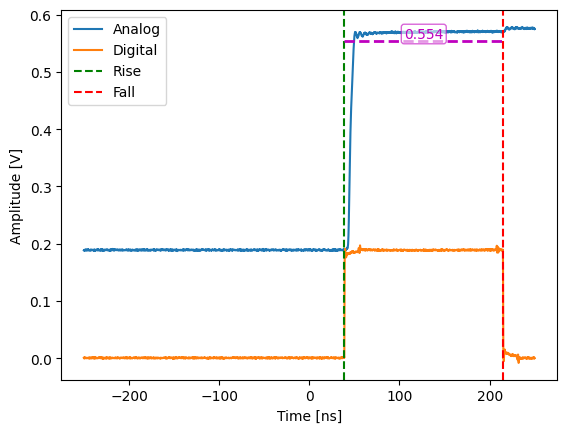

In [164]:

data_path = sorted_converted_files[0]
iCh = 1     # Ana Ch 2

iEvent =  0

rise_idx, fall_idx, time_arr, y_ana, y_dig = get_amp_time(data_path, iCh, iEvent, channel_map)

plt.plot(time_arr, y_ana, label="Analog")
plt.plot(time_arr, y_dig, label="Digital")
if rise_idx is not None:
    plt.axvline(time_arr[rise_idx], color="g", linestyle="--", label="Rise")
if fall_idx is not None:
    plt.axvline(time_arr[fall_idx], color="r", linestyle="--", label="Fall")

if rise_idx is not None and fall_idx is not None and fall_idx > rise_idx:
    mean_amp = y_ana[rise_idx:fall_idx].mean()
    plt.hlines(mean_amp, time_arr[rise_idx], time_arr[fall_idx],
               colors="m", linestyles="--", linewidth=2)
    
    x_mid = 0.5 * (time_arr[rise_idx] + time_arr[fall_idx])
    plt.text(x_mid, mean_amp, f"{mean_amp:.3f}",
             color="m", va="bottom", ha="center", fontsize=10,
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="m", alpha=0.6))

    
plt.xlabel("Time [ns]")  
plt.ylabel("Amplitude [V]")
plt.legend()
plt.show()


In [160]:
def process_file_matrix(path, analog_channels, ch_map, n_events=1000):
    """
    Parse one ROOT file and return amplitudes as a dense matrix:
        shape = (n_events_in_file, n_channels)
    Values are NaN where a channel/event failed edge detection.
    """
    with ur.open(path) as f:
        arr = f["pulse"].arrays(["channel"], library="np")["channel"]  # (events, channels, samples)

    n_ev = min(n_events, arr.shape[0])
    n_ch = len(analog_channels)
    amps = np.full((n_ev, n_ch), np.nan, dtype=np.float64)

    for iEvent in range(n_ev):
        for j, ana_idx in enumerate(analog_channels):
            dig_idx = ch_map[ana_idx]

            y_ana = arr[iEvent, ana_idx, :]
            y_dig = arr[iEvent, dig_idx, :]

            rise_idx, fall_idx, _, _ = find_pulse_edges(y_dig)
            if rise_idx is None or fall_idx is None or fall_idx <= rise_idx:
                continue
            amps[iEvent, j] = y_ana[rise_idx:fall_idx].mean()

    return amps  # (n_ev, n_ch)


def build_amp_cube(sorted_converted_files, analog_channels, ch_map, n_events=1000):
    """
    Build a 3D cube across files:
        cube.shape = (n_files, n_events, n_channels)
    Files with fewer events get NaN-padded to n_events.
    """
    n_files = len(sorted_converted_files)
    n_ch = len(analog_channels)
    cube = np.full((n_files, n_events, n_ch), np.nan, dtype=np.float64)

    for f_idx, scf in enumerate(tqdm(sorted_converted_files, desc="Files")):
        M = process_file_matrix(scf, analog_channels, ch_map, n_events=n_events)  # (n_ev_in_file, n_ch)
        n_ev = M.shape[0]
        cube[f_idx, :n_ev, :] = M

    return cube  # (n_files, n_events, n_channels)

In [168]:
converted_path = os.path.join(latest_run_dir, "converted")
converted_files = glob.glob(os.path.join(converted_path, "*.root"))
sorted_converted_files = sorted(
        converted_files,
        key=lambda path: int(re.search(r'run(\d+)\.root', path).group(1))
    )

channels = sorted(list(channel_map.keys()))
print(channels)

# cube = build_amp_cube(sorted_converted_files, channels, channel_map, n_events=1000)

[1, 2, 3]


Files:  34%|███▍      | 227/661 [05:02<09:23,  1.30s/it]

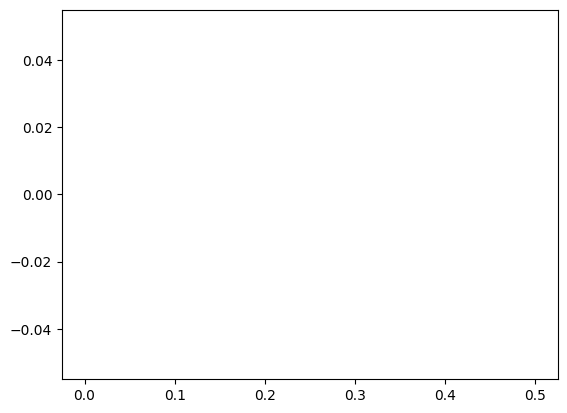

In [166]:
y_min, y_max = 0., 0.5   
bins_y       = 120         
y_edges      = np.linspace(y_min, y_max, bins_y + 1)

x_edges = np.linspace(
    x_range[0] - step_x / 2,
    x_range[-1] + step_x / 2,
    len(x_range)  + 1
)

chan_idx = 0
file_idx = 0
amps = cube[file_idx, :, chan_idx].ravel() 
plt.hist(amps, bins=np.linspace(y_min, y_max, bins_y + 1))
plt.show()


# for file_idx in range(0, 1000):
#     amps = cube[file_idx, :, chan_idx].ravel() 
#     plt.hist(amps, bins=np.linspace(y_min, y_max, bins_y + 1))
#     plt.show()

In [143]:
cube[file_idx, :, chan_idx].ravel() 

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.45357168,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.45683613, 0.45683613,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.4568361 ,
              nan,        nan, 0.45683613,        nan,        nan,
       0.4568361 ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.45683616,        nan,        nan,
              nan,        nan,        nan,        nan,        

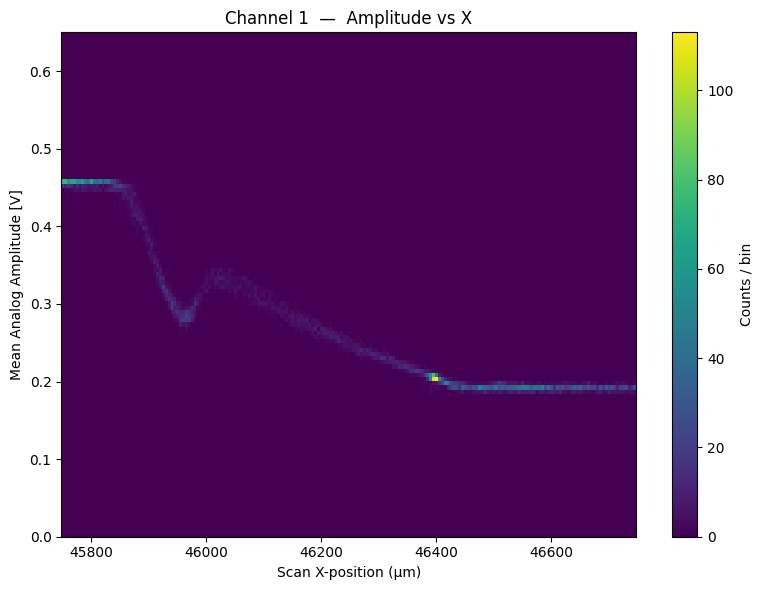

In [144]:
y_min, y_max = 0., 0.65   
bins_y       = 120         
y_edges      = np.linspace(y_min, y_max, bins_y + 1)

x_edges = np.linspace(
    x_range[0] - step_x / 2,
    x_range[-1] + step_x / 2,
    len(x_range)  + 1
)

chan_idx = 0
amps = cube[:, :, chan_idx].ravel()                 
xrep = np.repeat(x_range, cube.shape[1])             

# mask = np.isfinite(amps)
# amps = amps[mask]
# xrep = xrep[mask]

# keep = (amps >= y_min) & (amps <= y_max)
# amps = amps[keep]
# xrep = xrep[keep]

plt.figure(figsize=(8, 6))
h = plt.hist2d(xrep, amps,
                bins=[x_edges, y_edges],
                cmap="viridis")
plt.colorbar(h[3], label="Counts / bin")
plt.xlabel("Scan X-position (µm)")         
plt.ylabel("Mean Analog Amplitude [V]")
plt.title(f"Channel {channels[chan_idx]}  —  Amplitude vs X")
plt.tight_layout()
plt.show()

In [167]:
y_min, y_max = 0., 0.65   
bins_y       = 120         
y_edges      = np.linspace(y_min, y_max, bins_y + 1)

x_edges = np.linspace(
    x_range[0] - step_x / 2,
    x_range[-1] + step_x / 2,
    len(x_range)  + 1
)

channels = sorted(list(channel_map.keys()))
print(f"Processing 0-based analog channel indices: {channels}")

for chan_idx in range(len(channels)):
    amps = cube[:, :, chan_idx].ravel()
    xrep = np.repeat(x_range, cube.shape[1])

    mask = np.isfinite(amps)
    amps = amps[mask]
    xrep = xrep[mask]

    keep = (amps >= y_min) & (amps <= y_max)
    amps = amps[keep]
    xrep = xrep[keep]

    plt.figure(figsize=(8, 6))
    h = plt.hist2d(xrep, amps,
                   bins=[x_edges, y_edges],
                   cmap="viridis")
    plt.colorbar(h[3], label="Counts / bin")
    plt.xlabel("Scan X-position (µm)")
    plt.ylabel("Mean Analog Amplitude [V]")

    # --- MODIFICATION HERE ---
    # Get the actual channel number (2, 3, or 4) for the title
    # channels[chan_idx] gives the 0-based index (1, 2, or 3)
    # So we add 1 to get the 1-based channel number
    actual_channel_num = channels[chan_idx] + 1
    plt.title(f"Channel {actual_channel_num}  —  Amplitude vs X")
    # -------------------------

    plt.tight_layout()
    plt.show()

Processing 0-based analog channel indices: [1, 2, 3]


Files:   2%|▏         | 11/661 [00:17<16:58,  1.57s/it]


KeyboardInterrupt: 

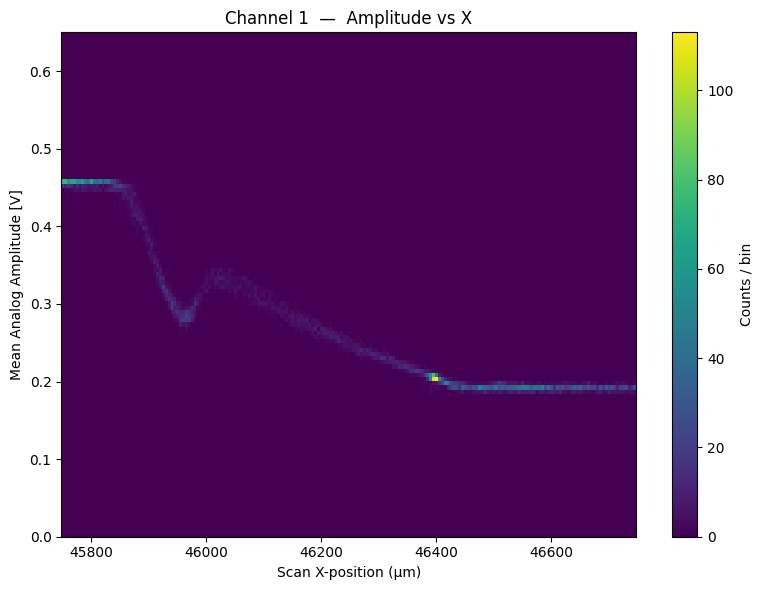

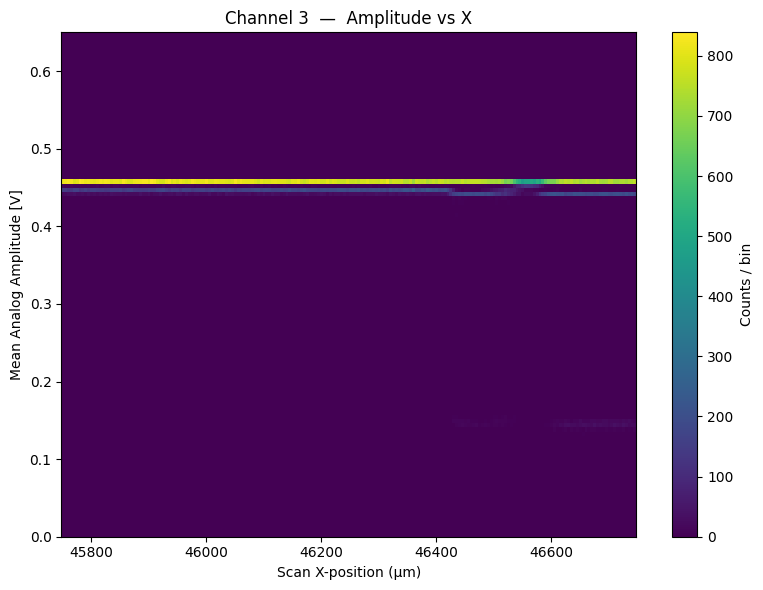

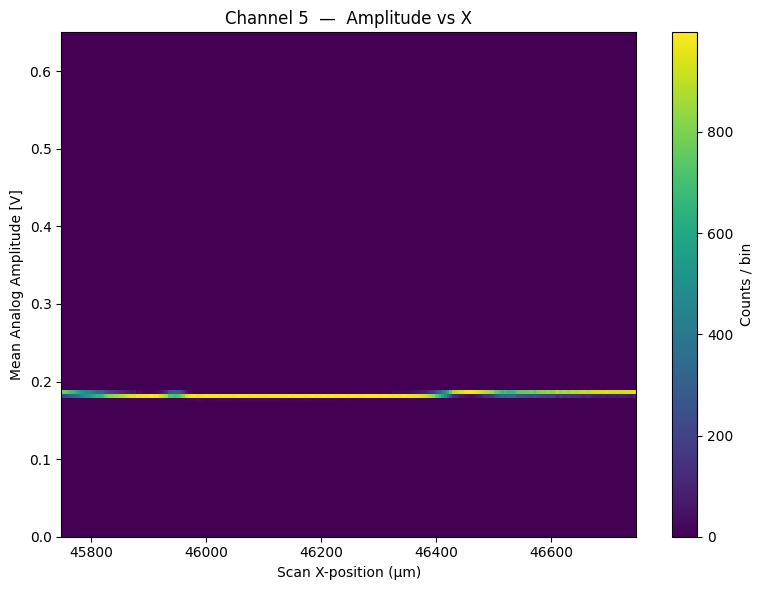

In [145]:
y_min, y_max = 0., 0.65   
bins_y       = 120         
y_edges      = np.linspace(y_min, y_max, bins_y + 1)

x_edges = np.linspace(
    x_range[0] - step_x / 2,
    x_range[-1] + step_x / 2,
    len(x_range)  + 1
)

for chan_idx in range(len(channels)):          
    amps = cube[:, :, chan_idx].ravel()                 
    xrep = np.repeat(x_range, cube.shape[1])             

    mask = np.isfinite(amps)
    amps = amps[mask]
    xrep = xrep[mask]

    keep = (amps >= y_min) & (amps <= y_max)
    amps = amps[keep]
    xrep = xrep[keep]

    plt.figure(figsize=(8, 6))
    h = plt.hist2d(xrep, amps,
                   bins=[x_edges, y_edges],
                   cmap="viridis")
    plt.colorbar(h[3], label="Counts / bin")
    plt.xlabel("Scan X-position (µm)")         
    plt.ylabel("Mean Analog Amplitude [V]")
    plt.title(f"Channel {channels[chan_idx]}  —  Amplitude vs X")
    plt.tight_layout()
    plt.show()